# Import all the libraries needed

In [ ]:
#Import all the necessary libraries 
from sklearn import metrics 
import pandas as pd
import numpy as np
import math
import category_encoders as ce
#Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification  
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
from tensorflow import keras
from tensorflow.keras import layers
#plotting
import matplotlib.pyplot as plt
import seaborn as seabornInstance 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read the dataset 

In [ ]:
df=pd.read_csv('data.csv')
MMSE_results={} #hold our accuracy results
GDS_results={}

In [ ]:
#rename columns names into shorter abbreviations
df.columns= df.columns.str.replace('Total Medical Outcome Study Social Factor','TMOSSF',regex=True)
df.columns= df.columns.str.replace('Medical Outcome Study Social Factor','TMOSSF',regex=True)
df.columns= df.columns.str.replace('Perceived Stress Scale','PSS',regex=True)
df.columns= df.columns.str.replace('Flourushing Scale','FS',regex=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 45 columns):
 #   Column                                                                        Non-Null Count  Dtype 
---  ------                                                                        --------------  ----- 
 0   ID                                                                            2254 non-null   int64 
 1   NEGERI                                                                        2254 non-null   object
 2   GENDER                                                                        2254 non-null   object
 3   AGE                                                                           2254 non-null   int64 
 4   Marital Status                                                                2254 non-null   object
 5   Tinggal                                                                       2254 non-null   object
 6   Smoking                                 

## Feature Engineering
Since most data has been already cleared and transformed accordingly, we're going to focus on the importance/utility of our features

In [ ]:
df.columns

Index(['ID', 'NEGERI', 'GENDER', 'AGE', 'Marital Status', 'Tinggal ',
       'Smoking', 'Rokok Sehari', 'Bekas Perokok - Tahun Berhenti',
       'Jika Kurang 1 Tahun Berapa Batang', 'Minum Alkohol', 'MMSE', 'GDS-15',
       'Pekerjaan Utama', 'Job Sector Previously',
       'Total Monthly main income (Full)', 'Total Monthly side_income',
       'Number of People Employed in Household',
       'Total Monthly Household_income', 'TMOSSF (Informational)',
       'TMOSSF (Tangible Support)', 'TMOSSF (Affective Support)',
       'TMOSSF (Positive Social Interaction)', 'Neighbourhood - General Feel',
       'Average Total Neighbourhood', 'Total Social Cohesion Scale ',
       'Quality Of Life', 'Total SWLS',
       'Perceived Stress Scale 1 (Unable to control)',
       'Perceived Stress Scale 2 (Ability to handle your personal problems)',
       'Perceived Stress Scale 3 (things were going your way)',
       'Perceived Stress Scale 4 (not overcome them)',
       'Flourushing Scale 1 : I lead 

In [ ]:
df['total_perceived'] = (df['PSS 1 (Unable to control)'].astype('int')+df['PSS 2 (Ability to handle your personal problems)'].astype('int')+df['PSS 2 (Ability to handle your personal problems)'].astype('int')+df['PSS 4 (not overcome them)'].astype('int'))/4
# 0 = Never, 1 = Often
df.loc[df['total_perceived'] <= 2, 'c_total_perceived'] = 0
df.loc[df['total_perceived'] > 2, 'c_total_perceived'] = 1

In [ ]:
df['total_flourishing'] = (df['FS 1 : I lead a purposeful and meaningful life.'].astype('int')+df['FS 2 : My social relationships are supportive and rewarding.'].astype('int')+df['FS 3 : I am engaged and interested in my daily activities.'].astype('int')+df[ 'FS 4 : I actively contribute to the happiness and well-being of others.'].astype('int')
+df['FS 5 : I am competent and capable in the activities that are important to me'].astype('int')+df['FS 6 : I am a good person and live a good life'].astype('int')+df[ 'FS 7 : I am optimistic about my future'].astype('int')+df['FS 8 : People respect me'].astype('int'))/8
# 0 = Disagree, 1 = Agree, 2= Neither agree nor disagree
df.loc[df['total_flourishing'] < 4, 'c_total_flourishing'] = 1
df.loc[df['total_flourishing'] > 4, 'c_total_flourishing'] = 0
df.loc[df['total_flourishing'] == 4, 'c_total_flourishing'] = 2

In [ ]:
df['total_income']= df['Total Monthly main income (Full)'].astype('int')+df['Total Monthly side_income'].astype('int')+df['Total Monthly Household_income'].astype('int')

In [ ]:
df.to_csv("datanew.csv")



In [ ]:
demographic_att = ['AGE','GENDER','NEGERI','Pekerjaan Utama','Job Sector Previously','Marital Status','Tinggal ','Number of People Employed in Household','total_income']
health_att = ['Smoking','Rokok Sehari', 'Bekas Perokok - Tahun Berhenti', 'Jika Kurang 1 Tahun Berapa Batang', 'Minum Alkohol','ADL','WHODAS_baseline']
social_att = ['sumLubben','Neighbourhood - General Feel', 'Average Total Neighbourhood','Total Social Cohesion Scale ', 'TMOSSF (Informational)',
              'TMOSSF (Tangible Support)','TMOSSF (Affective Support)',
              'TMOSSF (Positive Social Interaction)']
psychology_att = ['Quality Of Life', 'Total SWLS','Total_EpQ(Average)','Total_Loneliness ', 'total_perceived', 'c_total_perceived','total_flourishing','c_total_flourishing']
all_att = demographic_att+health_att+social_att+psychology_att

MMSE = df["MMSE"]
GDS = df["GDS-15"]

Let's start by changing our dataset a little bit

In [ ]:
thisdict = {
    "Severe": 0,
    "Mild": 1,
    "Normal": 2
}
MMSE= df['MMSE'].map(thisdict)

In [ ]:
dd = df[demographic_att]
dh = df[health_att]
ds = df[social_att]
dp = df[psychology_att]

In [ ]:
final_demographic = pd.get_dummies(dd)
final_health = pd.get_dummies(dh)
final_social = pd.get_dummies(ds)
final_psychology = pd.get_dummies(dp)

all_att = final_demographic+final_health+final_social+final_psychology
final_df = pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1)

## Statistical tests
Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

We only select the top 10 best features for each domain

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#let's test out demographic ds
X = final_demographic.copy() 
y = MMSE
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


                                  Specs         Score
2                          total_income  87350.890678
0                                   AGE    136.197422
13             Marital Status_Balu/Duda     91.827470
6                       NEGERI_Kelantan     64.840218
3                         GENDER_Lelaki     47.716987
8                       NEGERI_Selangor     45.357177
11  Job Sector Previously_Public Sector     44.475215
4                      GENDER_Perempuan     44.288221
15             Marital Status_Berkahwin     38.676709
18                   Tinggal _Sendirian     19.800510


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#let's test out demographic ds
X = final_demographic.copy() 
y = GDS
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                       Specs        Score
2                               total_income  6086.136703
5                               NEGERI_Johor    19.775973
7                               NEGERI_Perak    10.797455
27  Number of People Employed in Household_8     8.550847
28  Number of People Employed in Household_9     8.550847
3                              GENDER_Lelaki     7.491025
6                            NEGERI_Kelantan     7.014936
4                           GENDER_Perempuan     6.952748
11       Job Sector Previously_Public Sector     6.747646
13                  Marital Status_Balu/Duda     6.318677


In [ ]:
#this cell of code is not run for experiment 1 part b where all features will be taken into consideration instead of just top 10 
final_demographic = final_demographic[['total_income','AGE','Marital Status_Balu/Duda','NEGERI_Kelantan','GENDER_Lelaki','NEGERI_Selangor','Job Sector Previously_Public Sector','GENDER_Perempuan','Marital Status_Berkahwin','Tinggal _Sendirian']]

In [ ]:
X = final_health.copy()
y = MMSE
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                Specs       Score
1      Bekas Perokok - Tahun Berhenti  134.515139
2   Jika Kurang 1 Tahun Berapa Batang   38.633508
11               WHODAS_baseline_None   32.567363
14               WHODAS_baseline_Some   28.496700
0                        Rokok Sehari   17.319936
7                    Minum Alkohol_Ya   12.252523
10           WHODAS_baseline_Moderate   11.564649
3               Smoking_Bekas Perokok    7.847389
13            WHODAS_baseline_Serious    3.891140
9    ADL_Low - Patient very dependent    2.521723


In [ ]:
#this cell of code is not run for experiment 1 part b where all features will be taken into consideration instead of just top 10 
final_health = final_health[['Bekas Perokok - Tahun Berhenti','Jika Kurang 1 Tahun Berapa Batang','WHODAS_baseline_None','WHODAS_baseline_Some','Rokok Sehari','Minum Alkohol_Ya','WHODAS_baseline_Moderate','Smoking_Bekas Perokok','WHODAS_baseline_Serious','ADL_Low - Patient very dependent']]

In [ ]:
X = final_social.copy()
y = MMSE
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                                Specs     Score
20         TMOSSF (Tangible Support)_None of the time  7.393480
8          Average Total Neighbourhood_Very Satisfied  7.173740
1                    sumLubben_More Social Engagement  6.886868
14             TMOSSF (Informational)_All of the time  6.637006
18          TMOSSF (Tangible Support)_All of the time  6.586687
22         TMOSSF (Affective Support)_All of the time  6.133103
16            TMOSSF (Informational)_None of the time  5.497567
12        Total Social Cohesion Scale _Strongly Agree  4.177140
26  TMOSSF (Positive Social Interaction)_All of th...  3.966675
24        TMOSSF (Affective Support)_None of the time  2.937191


In [ ]:
#this cell of code is not run for experiment 1 part b where all features will be taken into consideration instead of just top 10 
final_social = final_social[['TMOSSF (Tangible Support)_None of the time','Average Total Neighbourhood_Very Satisfied','sumLubben_More Social Engagement','TMOSSF (Informational)_All of the time','TMOSSF (Tangible Support)_All of the time','TMOSSF (Affective Support)_All of the time','TMOSSF (Informational)_None of the time','Total Social Cohesion Scale _Strongly Agree','TMOSSF (Positive Social Interaction)_All of the time','TMOSSF (Affective Support)_None of the time']]

In [ ]:
X = final_psychology.copy()
y = MMSE
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k= 5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 8 best features

                                 Specs      Score
9               Total_EpQ(Average)_Yes  20.763942
12  Total_Loneliness _Some of the time  10.530435
5                     Total SWLS_Agree   9.659087
7                   Total SWLS_Neutral   8.343189
0                      Quality Of Life   4.589705
3                    total_flourishing   3.244154
8                Total_EpQ(Average)_No   2.861462
6                  Total SWLS_Disagree   1.832522
1                      total_perceived   0.906974
11             Total_Loneliness _Often   0.780516


In [ ]:
#this cell of code is not run for experiment 1 part b where all features will be taken into consideration instead of just top 10 
final_psychology = final_psychology[['Total_EpQ(Average)_Yes','Total_Loneliness _Some of the time','Total SWLS_Agree','Total SWLS_Neutral','Quality Of Life','total_flourishing','Total_EpQ(Average)_No','Total SWLS_Disagree','Total_Loneliness _Often','Total_Loneliness _Hardly ever']]

### K-modes as Clustering Algorithm for Categorical Data Type

In [ ]:
final_df = pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1)

In [ ]:
# Elbow curve to find optimal K
cost = []
df = final_df
df["MMSE"]=MMSE
K = range(2,11)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)
print(cost)
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

NameError: ignored

In [ ]:
#Check the cluster number 5 according to the previous graph
kmode = KModes(n_clusters=5, init = "random", n_init = 2 , verbose=1)
clusters = kmode.fit_predict(df)

In [ ]:
# Add the cluster to the dataframe
df['Cluster Labels'] = kmode.labels_
df['Segment'] = df['Cluster Labels'].map({0:'First', 1:'Second',2:'Third',3:'Fourth',4:'Fifth'})
# Order the cluster
df['Segment'] = df['Segment'].astype('category')
df['Segment'] = df['Segment'].cat.reorder_categories(['First', 'Second','Third','Fourth','Fifth'])
# Columns for centroids
list_col = ['Cluster Labels', 'Segment']
cols = [col for col in df if col not in list_col]
# Create an index for cluster interpretation
index = ['First Cluster', 'Second Cluster','Third Cluster','Fourth Cluster','Fifth Cluster']
# Create the data frame
pd.DataFrame(kmode.cluster_centroids_, columns = cols, index = index)

# Models
### Decision tree model 
Test the model on 30 70 distribution:
*Demographic vs MMSE
*health vs MMSE
*social vs MMSE
*Demo + health vs MMSe
...
*Demo + health + Social vs MMSE

*Psy vs GDS

In [ ]:
# Import the model you want to use
from sklearn.tree import DecisionTreeClassifier
#Make an instance of the Model
clf = DecisionTreeClassifier(max_depth = 6,random_state = 0)

def partition_DT(portion,features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=portion, random_state=1)
    #Train the model on the data
    clf.fit(X_train, y_train)
    # Predict labels of unseen (test) data
    y_pred = clf.predict(X_test)
    print("Accuracy of DecisionTree:",metrics.accuracy_score(y_test, y_pred)*100)
    return metrics.accuracy_score(y_test, y_pred)


print("\nMeasuring prediction on MMSE")
MMSE_results["Decision Tree"]=[
    partition_DT(0.2,final_demographic,MMSE)
    ,partition_DT(0.2,final_health,MMSE)
    ,partition_DT(0.2,final_social,MMSE)
    ,partition_DT(0.2,final_psychology,MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_social],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_social,final_health],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_social,final_psychology],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_health,final_psychology],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_psychology],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),MMSE)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),MMSE)
]
print("\nMeasuring prediction on GDS")
GDS_results["Decision Tree"]=[    
     partition_DT(0.2,final_demographic,GDS)
    ,partition_DT(0.2,final_health,GDS)
    ,partition_DT(0.2,final_social,GDS)
    ,partition_DT(0.2,final_psychology,GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_social],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_social,final_health],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_social,final_psychology],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_health,final_psychology],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_psychology],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),GDS)
    ,partition_DT(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),GDS)
]




Measuring prediction on MMSE
Accuracy of DecisionTree: 69.40133037694012
Accuracy of DecisionTree: 61.86252771618626
Accuracy of DecisionTree: 62.08425720620843
Accuracy of DecisionTree: 61.64079822616409
Accuracy of DecisionTree: 70.06651884700665
Accuracy of DecisionTree: 68.51441241685144
Accuracy of DecisionTree: 61.4190687361419
Accuracy of DecisionTree: 60.97560975609756
Accuracy of DecisionTree: 61.86252771618626
Accuracy of DecisionTree: 67.62749445676275
Accuracy of DecisionTree: 68.95787139689578
Accuracy of DecisionTree: 68.95787139689578
Accuracy of DecisionTree: 66.74057649667405
Accuracy of DecisionTree: 61.86252771618626
Accuracy of DecisionTree: 67.84922394678492

Measuring prediction on GDS
Accuracy of DecisionTree: 90.02217294900223
Accuracy of DecisionTree: 90.02217294900223
Accuracy of DecisionTree: 89.80044345898004
Accuracy of DecisionTree: 90.2439024390244
Accuracy of DecisionTree: 89.80044345898004
Accuracy of DecisionTree: 88.69179600886919
Accuracy of Decisio

Let's visualize the decision tree of predicting GDS based on psychology features

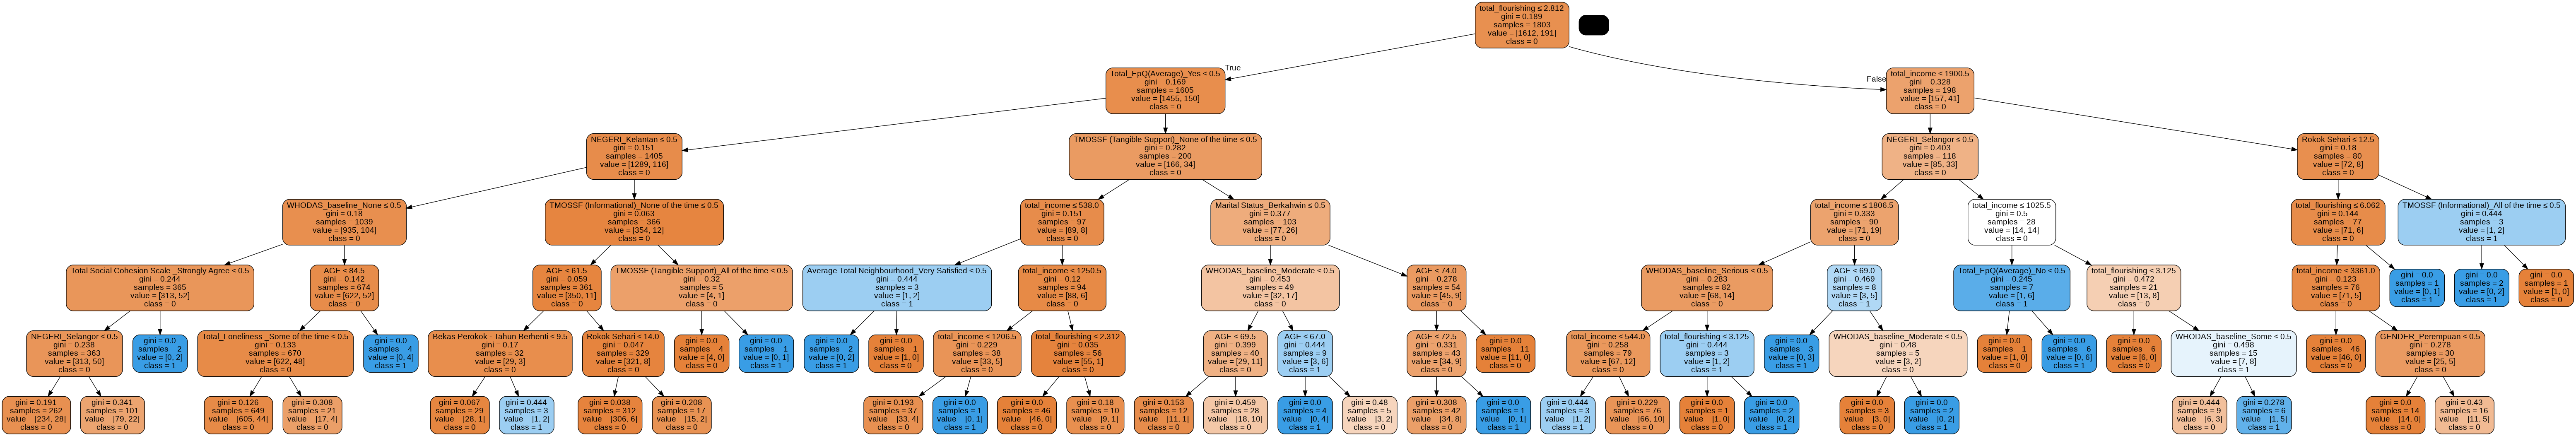

In [ ]:
#change the clf based on the variable calculated earlier, and the respective feature list

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = pd.concat([final_demographic,final_health,final_social,final_psychology]).columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('GDS.png')
Image(graph.create_png())

## MLP classifier

In [ ]:
#MLP Classifier
def partition_MLP(portion,features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=portion, random_state=1)
    clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_pred, y_test)
    print("Accuracy of MLPClassifier :", accuracy(cm)*100)
    return accuracy(cm)
def accuracy(confusion_matrix):
        diagonal_sum = confusion_matrix.trace()
        sum_of_all_elements = confusion_matrix.sum()
        return diagonal_sum / sum_of_all_elements
    
print("\nMeasuring prediction on MMSE")
MMSE_results["Mlp"]=[
   partition_MLP(0.2,final_demographic,MMSE)
    ,partition_MLP(0.2,final_health,MMSE)
    ,partition_MLP(0.2,final_social,MMSE)
    ,partition_MLP(0.2,final_psychology,MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_social],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_social,final_health],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_social,final_psychology],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_health,final_psychology],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_psychology],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),MMSE)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),MMSE)
]

print("\nMeasuring prediction on GDS")
GDS_results["Mlp"]=[    
     partition_MLP(0.2,final_demographic,GDS)
    ,partition_MLP(0.2,final_health,GDS)
    ,partition_MLP(0.2,final_social,GDS)
    ,partition_MLP(0.2,final_psychology,GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_social],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_social,final_health],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_social,final_psychology],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_health,final_psychology],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_psychology],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),GDS)
    ,partition_MLP(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),GDS)
]


Measuring prediction on MMSE
Accuracy of MLPClassifier : 32.37250554323725
Accuracy of MLPClassifier : 62.08425720620843
Accuracy of MLPClassifier : 62.08425720620843
Accuracy of MLPClassifier : 62.52771618625277
Accuracy of MLPClassifier : 62.08425720620843
Accuracy of MLPClassifier : 42.572062084257205
Accuracy of MLPClassifier : 61.64079822616409
Accuracy of MLPClassifier : 60.97560975609756
Accuracy of MLPClassifier : 61.4190687361419
Accuracy of MLPClassifier : 62.3059866962306
Accuracy of MLPClassifier : 61.19733924611973
Accuracy of MLPClassifier : 21.507760532150776
Accuracy of MLPClassifier : 62.74944567627494
Accuracy of MLPClassifier : 62.08425720620843
Accuracy of MLPClassifier : 63.63636363636363

Measuring prediction on GDS
Accuracy of MLPClassifier : 89.80044345898004
Accuracy of MLPClassifier : 90.02217294900223
Accuracy of MLPClassifier : 90.02217294900223
Accuracy of MLPClassifier : 90.02217294900223
Accuracy of MLPClassifier : 90.02217294900223
Accuracy of MLPClassi

In [ ]:
#KNN Classifier
def partition_KNN(portion,features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=portion, random_state=1)
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
    print("Accuracy of KNNClassifier :", accuracies.mean()*100)
    return accuracy(cm)
    
print("\nMeasuring prediction on MMSE")
MMSE_results["Knn"]=[
   partition_KNN(0.2,final_demographic,MMSE)
    ,partition_KNN(0.2,final_health,MMSE)
    ,partition_KNN(0.2,final_social,MMSE)
    ,partition_KNN(0.2,final_psychology,MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_social],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_social,final_health],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_social,final_psychology],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_health,final_psychology],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_psychology],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),MMSE)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),MMSE)
]

print("\nMeasuring prediction on GDS")
GDS_results["Knn"]=[    
     partition_KNN(0.2,final_demographic,GDS)
    ,partition_KNN(0.2,final_health,GDS)
    ,partition_KNN(0.2,final_social,GDS)
    ,partition_KNN(0.2,final_psychology,GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_social],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_social,final_health],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_social,final_psychology],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_health,final_psychology],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_psychology],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),GDS)
    ,partition_KNN(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),GDS)
]



Measuring prediction on MMSE
Accuracy of KNNClassifier : 61.784837323511354
Accuracy of KNNClassifier : 59.84315531000613
Accuracy of KNNClassifier : 59.674953959484355
Accuracy of KNNClassifier : 56.35758133824431
Accuracy of KNNClassifier : 60.840392879066904
Accuracy of KNNClassifier : 61.12154696132597
Accuracy of KNNClassifier : 53.52731737262124
Accuracy of KNNClassifier : 60.009515039901785
Accuracy of KNNClassifier : 56.13259668508286
Accuracy of KNNClassifier : 61.17587476979743
Accuracy of KNNClassifier : 61.17280540208717
Accuracy of KNNClassifier : 60.451810926949044
Accuracy of KNNClassifier : 61.23204419889502
Accuracy of KNNClassifier : 57.40761203192142
Accuracy of KNNClassifier : 60.728667894413746

Measuring prediction on GDS
Accuracy of KNNClassifier : 88.46286065070595
Accuracy of KNNClassifier : 89.18538980969919
Accuracy of KNNClassifier : 89.40669122160834
Accuracy of KNNClassifier : 87.63014119091469
Accuracy of KNNClassifier : 88.62952731737262
Accuracy of KNN

In [ ]:
def partition_SVC(portion,features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=portion, random_state=1)#Create the SVM model
    classifier = SVC(kernel = 'sigmoid')
    #Fit the model for the data
    classifier.fit(X_train, y_train)
    #Make the prediction
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy of SVCClassifier :", accuracy(cm)*100)
    return accuracy(cm)

print("\nMeasuring prediction on MMSE")
MMSE_results["Svc"]=[
partition_DT(0.2,final_demographic,MMSE)
    ,partition_SVC(0.2,final_health,MMSE)
    ,partition_SVC(0.2,final_social,MMSE)
    ,partition_SVC(0.2,final_psychology,MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_social],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_social,final_health],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_social,final_psychology],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_health,final_psychology],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_psychology],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),MMSE)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),MMSE)
]
print("\nMeasuring prediction on GDS")
GDS_results["Svc"]=[    
     partition_SVC(0.2,final_demographic,GDS)
    ,partition_SVC(0.2,final_health,GDS)
    ,partition_SVC(0.2,final_social,GDS)
    ,partition_SVC(0.2,final_psychology,GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_social],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_social,final_health],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_social,final_psychology],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_health,final_psychology],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_psychology],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),GDS)
    ,partition_SVC(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),GDS)
]




Measuring prediction on MMSE
Accuracy of DecisionTree: 69.40133037694012
Accuracy of SVCClassifier : 56.76274944567628
Accuracy of SVCClassifier : 56.98447893569845
Accuracy of SVCClassifier : 54.54545454545454
Accuracy of SVCClassifier : 46.11973392461197
Accuracy of SVCClassifier : 46.11973392461197
Accuracy of SVCClassifier : 56.76274944567628
Accuracy of SVCClassifier : 57.42793791574279
Accuracy of SVCClassifier : 57.42793791574279
Accuracy of SVCClassifier : 46.11973392461197
Accuracy of SVCClassifier : 46.34146341463415
Accuracy of SVCClassifier : 46.34146341463415
Accuracy of SVCClassifier : 46.34146341463415
Accuracy of SVCClassifier : 57.20620842572062
Accuracy of SVCClassifier : 46.34146341463415

Measuring prediction on GDS
Accuracy of SVCClassifier : 90.02217294900223
Accuracy of SVCClassifier : 82.70509977827051
Accuracy of SVCClassifier : 88.02660753880266
Accuracy of SVCClassifier : 88.91352549889136
Accuracy of SVCClassifier : 90.02217294900223
Accuracy of SVCClassifi

Neural network deep learning POG

### Naives Bayes 
https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python/notebook

In [ ]:

def partition_NB(portion, feature, target):
    df = feature
    numerical = [var for var in df.columns if df[var].dtype!='O']
    # find categorical variables
    categorical = [var for var in df.columns if df[var].dtype=='O']
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size= portion, random_state=0)
    encoder = ce.OneHotEncoder(cols=categorical)
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)
    cols = X_train.columns
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=[cols])
    X_test = pd.DataFrame(X_test, columns=[cols])
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    from sklearn.metrics import accuracy_score
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)*100))
    return accuracy_score(y_test, y_pred)
    
print("\nMeasuring prediction on MMSE")
MMSE_results["Nb"]=[
   partition_NB(0.2,final_demographic,MMSE)
    ,partition_NB(0.2,final_health,MMSE)
    ,partition_NB(0.2,final_social,MMSE)
    ,partition_NB(0.2,final_psychology,MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_social],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_social,final_health],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_social,final_psychology],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_health,final_psychology],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_psychology],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),MMSE)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),MMSE)
]
print("\nMeasuring prediction on GDS")
GDS_results["Nb"]=[    
     partition_NB(0.2,final_demographic,GDS)
    ,partition_NB(0.2,final_health,GDS)
    ,partition_NB(0.2,final_social,GDS)
    ,partition_NB(0.2,final_psychology,GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_social],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_social,final_health],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_social,final_psychology],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_health,final_psychology],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_psychology],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health,final_social],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health,final_psychology],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_psychology,final_social],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_psychology,final_health,final_social],axis=1),GDS)
    ,partition_NB(0.2,pd.concat([final_demographic,final_health,final_social,final_psychology],axis=1),GDS)
]


Measuring prediction on MMSE
Model accuracy score: 58.0931
Model accuracy score: 10.4213
Model accuracy score: 12.1951
Model accuracy score: 10.1996
Model accuracy score: 13.0820
Model accuracy score: 12.6386
Model accuracy score: 12.4169
Model accuracy score: 12.1951
Model accuracy score: 10.4213
Model accuracy score: 15.2993
Model accuracy score: 12.8603
Model accuracy score: 11.9734
Model accuracy score: 12.4169
Model accuracy score: 12.4169
Model accuracy score: 12.6386

Measuring prediction on GDS
Model accuracy score: 79.1574
Model accuracy score: 12.8603
Model accuracy score: 88.4701
Model accuracy score: 83.5920
Model accuracy score: 21.9512
Model accuracy score: 69.1796
Model accuracy score: 24.6120
Model accuracy score: 82.0399
Model accuracy score: 32.8160
Model accuracy score: 82.7051
Model accuracy score: 30.1552
Model accuracy score: 40.3548
Model accuracy score: 82.2616
Model accuracy score: 31.7073
Model accuracy score: 35.9202
